In [1]:
import os
import h5py
import gvar   as gv
import numpy  as np
import pandas as pd
from   matplotlib import pyplot as plt

def RatioFileString(name,ts,h,hss,q,l,p):
    return f'{name}T{ts}{h}_RW_{hss}_rot_rot{q}{l}_p{p}'

def format(v):
    return gv.gvar(
        v.mean(axis=0),
        v.std(axis=0) * np.sqrt(v.shape[0]-1)
    )

def plot(v,**kwargs):
    plt.errorbar(
        np.arange(len(v)),
        gv.mean(v),
        gv.sdev(v),
        fmt='.',
        **kwargs
    )

def jkCorr(data, bsize=1):
    if bsize==0:
        return data
    else:
        rData = (data.shape[0]//bsize)
        nData = rData*bsize
        dIn   = data[0:nData,:]

        avg   = dIn.mean(axis=0)

        base  = dIn.sum(axis=0) # avg * nData

        dOut  = dIn * 0.0

        for cf in range(rData):
            pvg = dIn[cf*bsize:(cf+1)*bsize,:].sum(axis=0)
            dOut[cf,:] = (base - pvg)/(nData - bsize)

        return dOut[:rData,:]

In the following cell import `FnalHISQMetadata` module giving the correct path

In [2]:
from b2heavy.FnalHISQMetadata import params # change

ens = 'Coarse-1'
mom = '000'
jk  = 11

mdata = params(ens)
Ta,Tb = mdata['hSinks']

heavy = '_k' + mdata['kBStr']
light = '_k' + mdata['kDStr']
qq    = '_m' + mdata['mlStr']

data = h5py.File(f'/Users/pietro/code/data_analysis/BtoD/Alex/Ensembles/FnalHISQ/a0.12/{mdata["hdf5File2"]}')
data = data['data']

$$
 R_{A_1}(\mathbf{p}_\perp,t,T) = \frac{ C_{B_{1S}\rightarrow D^*_a}^{A_j}(\mathbf{p}_\perp,t,T) \,\, C_{D^*_a\rightarrow B_{1S}}^{A_j}(\mathbf{p}_\perp,t,T) }{  C_{D^*_a\rightarrow D^*_{1S}}^{V_4}(\mathbf{0},t,T) \,\,   C_{B_{1S}\rightarrow B_{1S}}^{V_4}(\mathbf{0},t,T) } / \Biggl[\frac{Z_{D^*_a}(\mathbf p_\perp)}{\sqrt{Z_{D^*_a}(0)Z_{D_{1S}^*}(0)}} \frac{{M_{D^*}}^2}{{E^2_{D^*}}(\mathbb p)} e^{-({E_{D^*}}(\mathbb p) - M_{D^*})T}\Biggr]
$$ 

## Reading

in the following cells we read the data from the archive and we build the uncorrected ratio for each smearing and each sink time and we put it in a dictionary `data_read`

------------- tsink = 12 --------- smr = '1S' -------------------
P5_A2_V2_T12_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p000
V1_V4_V1_T12_k0.12201_RW_1S_rot_rot_m0.00507_k0.12201_p000
P5_V4_P5_T12_k0.08574_RW_1S_rot_rot_m0.00507_k0.08574_p000
------------- tsink = 13 --------- smr = '1S' -------------------
P5_A2_V2_T13_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p000
V1_V4_V1_T13_k0.12201_RW_1S_rot_rot_m0.00507_k0.12201_p000
P5_V4_P5_T13_k0.08574_RW_1S_rot_rot_m0.00507_k0.08574_p000
------------- tsink = 12 --------- smr = 'RW' -------------------
P5_A2_V2_T12_k0.08574_RW_RW_rot_rot_m0.00507_k0.12201_p000
V1_V4_V1_T12_k0.12201_RW_RW_rot_rot_m0.00507_k0.12201_p000
P5_V4_P5_T12_k0.08574_RW_1S_rot_rot_m0.00507_k0.08574_p000
------------- tsink = 13 --------- smr = 'RW' -------------------
P5_A2_V2_T13_k0.08574_RW_RW_rot_rot_m0.00507_k0.12201_p000
V1_V4_V1_T13_k0.12201_RW_RW_rot_rot_m0.00507_k0.12201_p000
P5_V4_P5_T13_k0.08574_RW_1S_rot_rot_m0.00507_k0.08574_p000


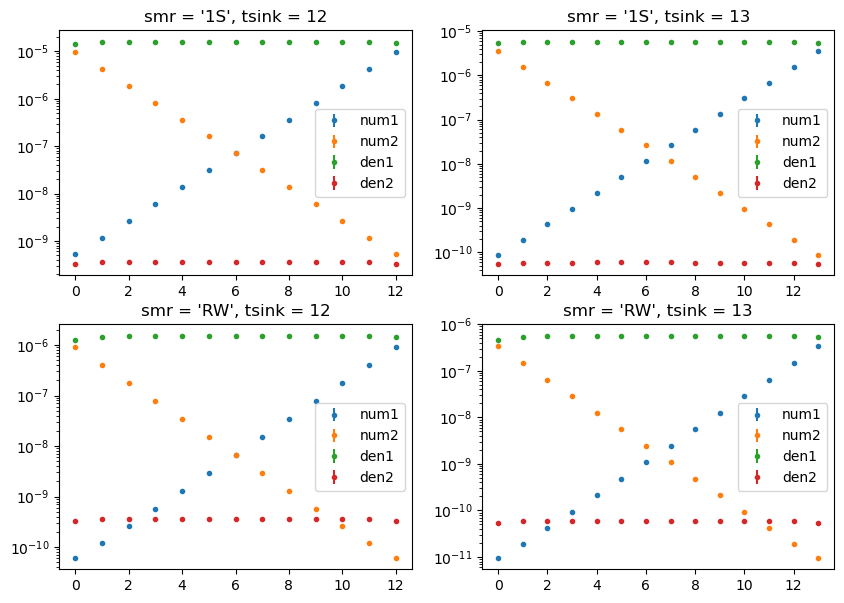

In [5]:
fig,ax = plt.subplots(2,2,figsize=(10,7))

data_read = {}
for i,smr in enumerate(['1S','RW']):
    data_read[smr] = {}
    for j,tsink in enumerate([Ta,Tb]):
        print(f'------------- {tsink = } --------- {smr = } -------------------')

        # Numerator 1 ===========================================================
        corr = RatioFileString('P5_A2_V2_',tsink,heavy,smr,qq,light,mom)
        num1 = jkCorr(data[corr][:,:(tsink+1)], bsize=jk)
        print(corr)

        # Numerator 2 ===========================================================
        num2 = np.flip(num1,axis=-1)

        # Denominator 1 ===========================================================
        corr = RatioFileString('V1_V4_V1_',tsink,light,smr,qq,light,'000')
        den1 = jkCorr(data[corr][:,:(tsink+1)], bsize=jk)
        print(corr)

        # Denominator 2 ===========================================================
        corr = RatioFileString('P5_V4_P5_',tsink,heavy,'1S',qq,heavy,'000')
        den2 = jkCorr(data[corr][:,:(tsink+1)], bsize=jk)
        print(corr)

        data_read[smr][tsink] = num1 * num2 / den1 / den2





        v = format(num1)
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='num1',color='C0')
        v = format(num2)
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='num2',color='C1')
        v = format(den1)
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='den1',color='C2')
        v = format(den2)
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='den2',color='C3')

        ax[i,j].set_title(f'{smr = }, {tsink = }')
        ax[i,j].set_yscale('log')
        ax[i,j].legend()

-------------- tsink = 12 smr = '1S' --------------
[1.086(22) 0.878(19) 0.868(20) 0.868(21) 0.868(21) 0.871(20) 0.872(21)
 0.871(21) 0.866(21) 0.866(21) 0.867(20) 0.875(19) 1.071(22)]
13
-------------- tsink = 13 smr = '1S' --------------
[1.066(28) 0.902(25) 0.888(26) 0.873(26) 0.874(27) 0.877(28) 0.883(29)
 0.885(28) 0.885(28) 0.875(26) 0.873(26) 0.889(26) 0.903(25) 1.075(29)]
14
-------------- tsink = 12 smr = 'RW' --------------
[0.1371(50) 0.0915(34) 0.0862(32) 0.0837(31) 0.0826(30) 0.0826(30)
 0.0832(31) 0.0827(30) 0.0822(29) 0.0837(30) 0.0853(32) 0.0886(33)
 0.1197(44)]
13
-------------- tsink = 13 smr = 'RW' --------------
[0.1273(51) 0.0902(40) 0.0842(38) 0.0814(36) 0.0812(37) 0.0811(37)
 0.0814(37) 0.0818(38) 0.0815(37) 0.0813(37) 0.0813(37) 0.0834(38)
 0.0873(39) 0.1115(47)]
14


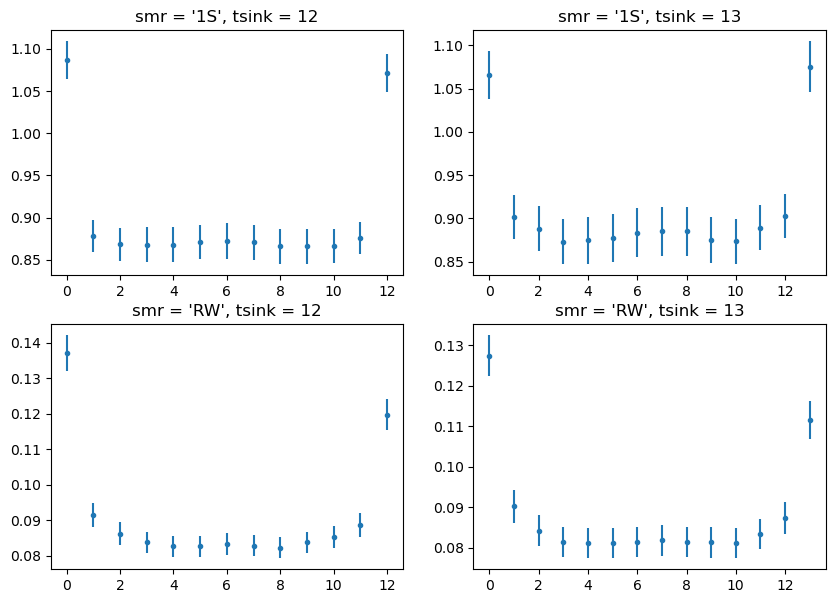

In [6]:
fig,ax = plt.subplots(2,2,figsize=(10,7))
for i,smr in enumerate(data_read):
    for j,tsink in enumerate(data_read[smr]):
        print(f'-------------- {tsink = } {smr = } --------------')
        print(format(data_read[smr][tsink]))
        print(len(format(data_read[smr][tsink])))

        v = format(data_read[smr][tsink])
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='num1',color='C0')
        ax[i,j].set_title(f'{smr = }, {tsink = }')

## Build correction factor

In the following cell we build the correction factor
$$\frac{Z_{D^*_a}(\mathbf p_\perp)}{\sqrt{Z_{D^*_a}(0)Z_{D_{1S}^*}(0)}} \frac{{M_{D^*}}^2}{{E^2_{D^*}}(\mathbf p)}$$

In [7]:
# This cell has only to be evaluated if next python cell is not

from b2heavy.ThreePointFunctions.types3pts import ratio_prerequisites

# frm = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/lattice24_old'
frm = '/Users/pietro/Desktop/lattice24/0.25/corr2_3'
req = ratio_prerequisites(ens,'RA1',mom,readfrom=frm)
req

FileNotFoundError: /Users/pietro/Desktop/lattice24/0.25/corr2_3/fit3pt_config_Coarse-1_xfstpar_000_fit.pickle is not a valid file

Fill the following cells with appropriate values

In [9]:
# req = {
#     'E0': 1.179682175085136,
#     'm0': 1.0809632444217314,
#     'Z0':   {'1S': 4.822281482026914, 'd': 0.04150728444106053},
#     'Zpar': {'1S': 1.6320372022086296, 'd': 0.033818481030701474},
#     'Zbot': {'1S': 1.1536983427438878, 'd': 0.02595700174869827},
# }

In [10]:
factor = {
    '1S': req['Zbot']['1S']/np.sqrt( req['Z0']['1S'] * req['Z0']['1S']) / req['wrecoil']**2, # (req['m0']/req['E0'])**2,
    'RW': req['Zbot']['d' ]/np.sqrt( req['Z0']['d' ] * req['Z0']['1S']) / req['wrecoil']**2, # (req['m0']/req['E0'])**2,
}

factor

{'1S': 0.7918686859018251, 'RW': 0.0845239877036805}

here we divide the data that we read by the correction factor

In [11]:
data_corr = {smr: {} for smr in data_read}

for smr in data_read:
    for tsink in data_read[smr]:
        data_corr[smr][tsink] = data_read[smr][tsink][:,:Ta+1] / factor[smr]
        print(f'-------------- {tsink = } {smr = } --------------')
        print(format(data_corr[smr][tsink]))

-------------- tsink = 12 smr = '1S' --------------
[0.926(25) 0.770(21) 0.767(22) 0.768(22) 0.768(23) 0.774(22) 0.772(23)
 0.773(23) 0.766(23) 0.767(22) 0.766(22) 0.768(21) 0.914(26)]
-------------- tsink = 13 smr = '1S' --------------
[0.946(31) 0.794(27) 0.785(28) 0.777(28) 0.778(29) 0.779(31) 0.777(31)
 0.778(31) 0.786(31) 0.778(29) 0.778(28) 0.786(28) 0.795(27)]
-------------- tsink = 12 smr = 'RW' --------------
[1.267(49) 0.860(35) 0.812(33) 0.787(31) 0.776(30) 0.776(29) 0.782(30)
 0.777(29) 0.771(30) 0.787(30) 0.804(32) 0.833(33) 1.106(43)]
-------------- tsink = 13 smr = 'RW' --------------
[1.206(54) 0.847(41) 0.791(39) 0.764(37) 0.756(38) 0.754(38) 0.752(38)
 0.756(39) 0.758(38) 0.757(38) 0.763(38) 0.783(39) 0.820(40)]


## Exponentials + smoothening

$$
\bar R_{A_1}(t,T) = \frac{1}{2}R_{A_1}(t,T) e^{(E-M)T} + \frac{1}{4}R_{A_1}(t,T+1) e^{(E-M)(T+1)} + \frac{1}{4}R_{A_1}(t+1,T+1) e^{(E-M)(T+1)}
$$

In [12]:
exp = np.exp(req['E0']-req['m0'])

barR = {}
barR['1S'] = data_corr['1S'][Ta  ]/2 * exp**Ta     +     data_corr['1S'][Tb]/4 * exp**Tb  +  np.roll(data_corr['1S'][Tb],-1,axis=1)/4 * exp**Tb
barR['RW'] = data_corr['RW'][Ta  ]/2 * exp**Ta     +     data_corr['RW'][Tb]/4 * exp**Tb  +  np.roll(data_corr['RW'][Tb],-1,axis=1)/4 * exp**Tb

In [13]:
for sm in ['1S','RW']:
    print(f'------------ {sm = } -------------')
    print(format(barR[sm]))

------------ sm = '1S' -------------
[1.064(25) 0.924(23) 0.917(24) 0.916(25) 0.916(25) 0.919(26) 0.918(26)
 0.921(26) 0.917(25) 0.915(25) 0.917(24) 0.923(23) 1.056(25)]
------------ sm = 'RW' -------------
[1.358(42) 0.994(33) 0.941(31) 0.916(30) 0.907(30) 0.906(29) 0.910(29)
 0.909(29) 0.906(30) 0.916(30) 0.934(31) 0.968(32) 1.255(40)]


<ErrorbarContainer object of 3 artists>

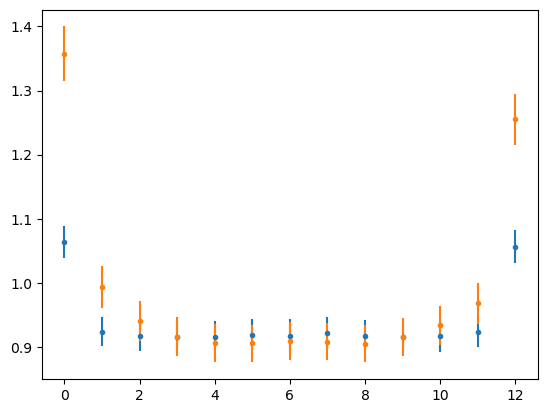

In [14]:
y1S = format(barR['1S'])
yRW = format(barR['RW'])
x   = np.arange(len(y1S))

plt.errorbar(x,gv.mean(y1S),gv.sdev(y1S),fmt='.')
plt.errorbar(x,gv.mean(yRW),gv.sdev(yRW),fmt='.')

# `CUSTOM`

In [15]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object
from b2heavy.ThreePointFunctions.corr3pts   import BINSIZE

In [16]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
io = RatioIO(ens,'RA1',mom,PathToDataDir=DATA_DIR)
robj = RatioFitter(
    io,
    jkBin     = BINSIZE[ens],
    smearing  = ['1S','RW'],
    **req
)

In [21]:
x,rr = robj.format()
r1S = rr['1S']
rRW = rr['RW']

<ErrorbarContainer object of 3 artists>

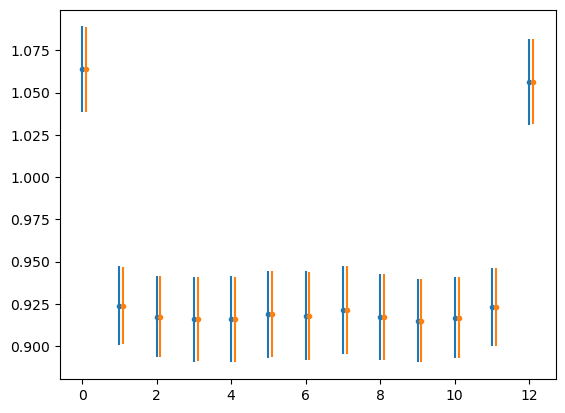

In [24]:
plt.errorbar(x,gv.mean(r1S),gv.sdev(r1S),fmt='.')
plt.errorbar(x+0.1,gv.mean(y1S),gv.sdev(y1S),fmt='.')

<ErrorbarContainer object of 3 artists>

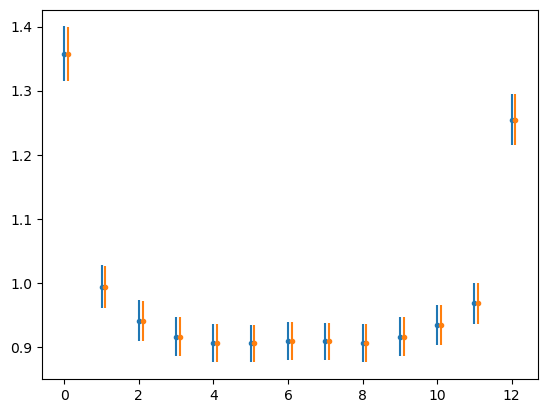

In [25]:
plt.errorbar(x    ,gv.mean(rRW),gv.sdev(rRW),fmt='.')
plt.errorbar(x+0.1,gv.mean(yRW),gv.sdev(yRW),fmt='.')